# Data collection

In [1]:
import datetime
import json
import os
import mthree
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentEncoder
from qiskit_research.mzm_generation import (
    KitaevHamiltonianExperiment,
    KitaevHamiltonianExperimentParameters,
)
from qiskit_research.mzm_generation.utils import transpile_circuit
from qiskit_research.mzm_generation.utils import pick_qubit_layout, orbital_combinations

from qiskit.circuit.library import RZGate
from qiskit_research.utils.dynamical_decoupling import get_instruction_durations

In [2]:
# get backend

# uncomment to use hardware backend
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend_name = 'ibmq_guadalupe'

# Aer simulator backend
# provider = None
# backend_name = "aer_simulator"

In [3]:
# experiment parameters
n_modes = 12
tunneling_values = [-1.0]
superconducting_values = [1.0]
chemical_potential_values = list(np.linspace(0.0, 3.0, num=5))
occupied_orbitals_list = list(orbital_combinations(n_modes, threshold=2))
# dynamical_decoupling_sequences = None
dynamical_decoupling_sequences=[None, 'X2pm', 'XY4pm', 'XY8pm']
num_dd_passes=1
uhrig_spacing = False
concat_layers = 1
shots = 10000
readout_calibration_shots = 10000

# pick qubits
qubits, backend_name, error_score = pick_qubit_layout(n_modes, backend_name, provider)
print(f"Using qubits {qubits}.")

# date
date = datetime.datetime.now().isoformat()

# create experiment
params = KitaevHamiltonianExperimentParameters(
    timestamp=date,
    backend_name=backend_name,
    qubits=qubits,
    n_modes=n_modes,
    tunneling_values=tunneling_values,
    superconducting_values=superconducting_values,
    chemical_potential_values=chemical_potential_values,
    occupied_orbitals_list=occupied_orbitals_list,
    dynamical_decoupling_sequences=dynamical_decoupling_sequences,
    num_dd_passes=num_dd_passes,
    uhrig_spacing=uhrig_spacing,
    concat_layers=concat_layers,
    seed=11364,
)
experiment = KitaevHamiltonianExperiment(params, provider)

print(f"Total number of circuits: {len(experiment.circuits())}")

Using qubits [7, 4, 1, 2, 3, 5, 8, 11, 14, 13, 12, 15].
Total number of circuits: 3000


In [10]:
dt = experiment.backend.configuration().dt

In [6]:
%%time

# schedule readout calibration
print("Scheduling readout calibration ...")
mit = mthree.M3Mitigation(experiment.backend)
mit.cals_from_system(qubits, shots=readout_calibration_shots, async_cal=True)

# schedule experiment jobs
print(f"Scheduling experiment ...")
# limit number of circuits per job to avoid timeouts
experiment.backend.configuration().max_experiments = 300
data = experiment.run(shots=shots)
if provider:
    # this only works if the Qiskit Experiments database service is available
    data.save()

# save readout calibration
filename = f"data/readout_calibration/{experiment.backend.name()}/{date}.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
print(f"Waiting for readout calibration data ...")
mit.cals_to_file(filename)
print(f"Readout calibration saved.")

# wait for experiment results
# data.block_for_results()

# save data
# filename = f"data/{params.backend_name}/{params.filename}.json"
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# with open(filename, "w") as f:
#     json.dump(data, f, cls=ExperimentEncoder)

# print(params.filename)

Scheduling readout calibration ...
Scheduling experiment ...


IBMQBackendApiError: 'Error submitting job: "(\'Connection aborted.\', ConnectionResetError(54, \'Connection reset by peer\'))"'

In [ ]:
data.block_for_results()

filename = f"data/{params.backend_name}/{params.filename}.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    json.dump(data, f, cls=ExperimentEncoder)

print(params.filename)

2022-06-20T15:34:55.954805_ibmq_guadalupe_n12


In [15]:
# dt

In [16]:
# print(get_instruction_durations(experiment.backend))

In [14]:
# experiment.circuits()[0].draw('mpl')

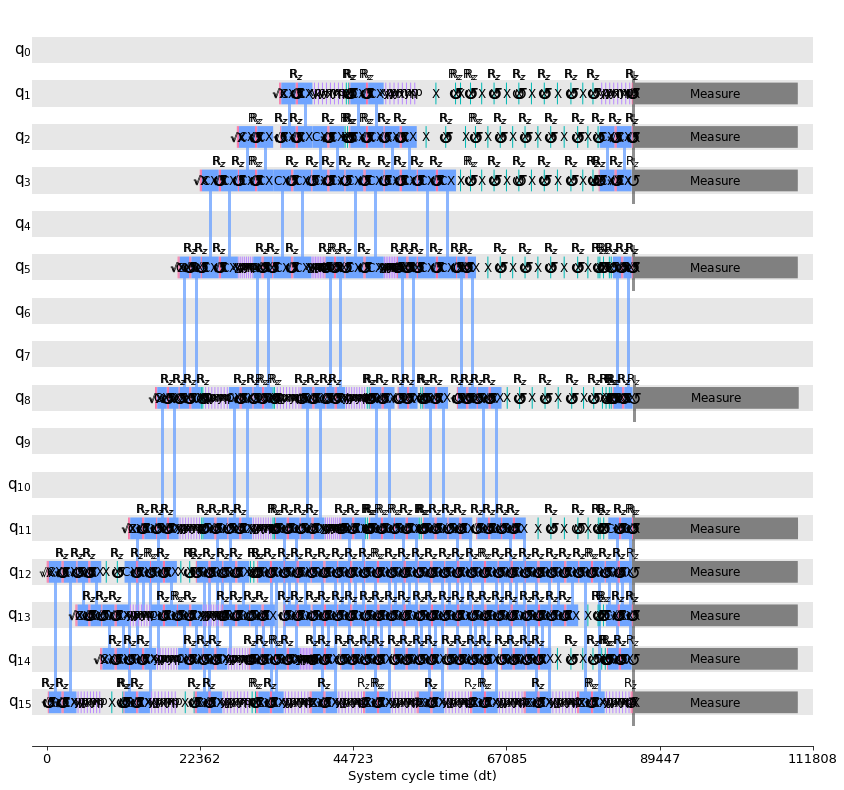

In [10]:
from qiskit.visualization import timeline_drawer

circ = transpile_circuit(
    experiment.circuits()[-1],
    experiment.backend,
    initial_layout=list(experiment.physical_qubits),
    dynamical_decoupling_sequence=dynamical_decoupling_sequences[-1],
    num_dd_passes=1,
    uhrig_spacing=False,
    concat_layers=1,
    pulse_scaling=experiment.params.pulse_scaling,
    pauli_twirling=bool(experiment.params.num_twirled_circuits),
    seed=experiment.rng,
)
timeline_drawer(circ)
# i = 0
# for circuit in experiment.circuits():
#     transpile_circuit(
#         circuit,
#         experiment.backend,
#         initial_layout=list(experiment.physical_qubits),
#         dynamical_decoupling_sequence=dynamical_decoupling_sequences[0],
#         num_dd_passes=1,
#         uhrig_spacing=False,
#         concat_layers=1,
#         pulse_scaling=experiment.params.pulse_scaling,
#         pauli_twirling=bool(experiment.params.num_twirled_circuits),
#         seed=experiment.rng,
#     )
#     i += 1

In [12]:
# transpile_circuit(
#     experiment.circuits()[0],
#     experiment.backend,
#     initial_layout=list(experiment.physical_qubits),
#     dynamical_decoupling_sequence=dynamical_decoupling_sequences[0],
#     num_dd_passes=3,
#     pulse_scaling=experiment.params.pulse_scaling,
#     pauli_twirling=bool(experiment.params.num_twirled_circuits),
#     seed=experiment.rng,
# ).draw('mpl')

In [9]:
# wait for experiment results
data.block_for_results()

# save data
filename = f"data/{params.filename}.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    json.dump(data, f, cls=ExperimentEncoder)

print(params.filename)

2022-06-03T09:18:18.833925_ibmq_kolkata_n8


In [7]:
from qiskit.visualization import timeline_drawer

circ = transpile_circuit(
    experiment.circuits()[3],
    experiment.backend,
    initial_layout=list(experiment.physical_qubits),
    dynamical_decoupling_sequence=dynamical_decoupling_sequences[0],
    num_dd_passes=1,
    uhrig_spacing=False,
    concat_layers=1,
    pulse_scaling=experiment.params.pulse_scaling,
    pauli_twirling=bool(experiment.params.num_twirled_circuits),
    seed=experiment.rng,
)
# timeline_drawer(circ)